In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

# import torchbearer
# from torchbearer import Trial
# from torchbearer.callbacks import CosineAnnealingLR

import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy

from IPython.display import Image
from tqdm.notebook import tqdm
from math import *

In [2]:
# Set dataset and model

# Dataset
dataset = torchvision.datasets.oxford_iiit_pet

# Pre-trained models of ViT: 
# torchvision.models.vit_b_16/vit_b_32/vit_l_16/vit_l_32
from torchvision.models import vit_b_16
model = vit_b_16(pretrained=True)

model_filename = "pets-vitb16"

warmup_epoch = 5
num_epoch = 7

lr_warmup = 1e-3
lr_base = 1e-2
lr_min = 1e-3

device = "cuda:3" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda:3'

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224)
])
train_set = torchvision.datasets.OxfordIIITPet("./data", split= "trainval", download = True, transform=transform)
test_set = torchvision.datasets.OxfordIIITPet("./data", split= "test", download = True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [5]:
# # 如果Intel的Windows上matplotlib会导致内核重启就执行下这个
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

# print(train_set[0][0].shape)
# plt.imshow(train_set[0][0].permute(1,2,0).numpy()[:,:,::])
# plt.show()

In [6]:
in_features = model.heads[0].in_features
in_features

768

In [7]:
model.heads = nn.Linear(in_features, 37) # set in_features and out_features
model.train()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [8]:
# Freeze other layers unless it is self_attention or mlp_head
for name, param in model.named_parameters():
    if ('self_attention' in name) or ('head' in name):
        print("Unfreeze " + name)
        param.requires_grad = True
    else:
        print("Freeze " + name)
        param.requires_grad = False

# optimiser1 = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
#                       lr=lr_warmup,
#                       momentum=0.9) #only optimse non-frozen layers
# optimiser2 = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
#                       lr=lr_base,
#                       momentum=0.9) #only optimse non-frozen layers


Freeze class_token
Freeze conv_proj.weight
Freeze conv_proj.bias
Freeze encoder.pos_embedding
Freeze encoder.layers.encoder_layer_0.ln_1.weight
Freeze encoder.layers.encoder_layer_0.ln_1.bias
Unfreeze encoder.layers.encoder_layer_0.self_attention.in_proj_weight
Unfreeze encoder.layers.encoder_layer_0.self_attention.in_proj_bias
Unfreeze encoder.layers.encoder_layer_0.self_attention.out_proj.weight
Unfreeze encoder.layers.encoder_layer_0.self_attention.out_proj.bias
Freeze encoder.layers.encoder_layer_0.ln_2.weight
Freeze encoder.layers.encoder_layer_0.ln_2.bias
Freeze encoder.layers.encoder_layer_0.mlp.linear_1.weight
Freeze encoder.layers.encoder_layer_0.mlp.linear_1.bias
Freeze encoder.layers.encoder_layer_0.mlp.linear_2.weight
Freeze encoder.layers.encoder_layer_0.mlp.linear_2.bias
Freeze encoder.layers.encoder_layer_1.ln_1.weight
Freeze encoder.layers.encoder_layer_1.ln_1.bias
Unfreeze encoder.layers.encoder_layer_1.self_attention.in_proj_weight
Unfreeze encoder.layers.encoder_laye

In [9]:
# Reading whole dataloader into memory can improve the speed of training
train_loader = list(train_loader)
test_loader = list(test_loader)

In [10]:
train_set

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: ./data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
           )

In [11]:
# model.load_state_dict(torch.load("model/" + model_filename))
# loss_function = nn.CrossEntropyLoss()
# trial = Trial(model, optimiser2, loss_function, metrics=['loss', 'accuracy']).to(device)
# trial.with_generators(train_loader, test_generator=test_loader)

In [12]:
loss_function = nn.CrossEntropyLoss()


In [13]:
lr = lr_base
def adjust_learning_rate(optimizer, current_epoch, max_epoch, lr_min=lr_min, lr_max=lr_base, warmup=True):
    if current_epoch < warmup_epoch:
        lr = lr_max * (current_epoch+1) / (warmup_epoch+1)
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("Learning rate is set to "+str(lr))

optimiser = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=lr,
                      momentum=0.9) #only optimse non-frozen layers
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

In [14]:
results = []

for epoch in range(warmup_epoch+num_epoch):
    running_loss = 0
    train_acc = 0
    
    adjust_learning_rate(optimizer=optimiser,
                        current_epoch=epoch,
                        max_epoch=warmup_epoch+num_epoch)
    with tqdm(train_loader, desc='Train(epoch'+str(epoch)+')') as t:
        total = 0
        correct = 0
        for data in t:
            model.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimiser.step()
            
            pred = torch.argmax(F.softmax(outputs), dim=1)
            total += len(labels)
            correct += sum(pred == labels)
            
        train_acc = (100.0 * correct) / total

        t.set_postfix(running_loss=running_loss,
                      runing_acc=train_acc)
            
    print("epoch %d/%d:(tr)loss=%.4f" % (epoch, warmup_epoch+num_epoch, running_loss))
    print("epoch %d/%d:(tr)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, train_acc))
    
    test_running_loss = 0
    test_acc = 0
            
    with tqdm(test_loader, desc='test'+str(epoch)) as t:
        with torch.no_grad():
            total = 0
            correct = 0
            for data in t:
                model.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)
                test_running_loss += loss.item()

                pred = torch.argmax(F.softmax(outputs), dim=1)
                total += len(labels)
                correct += sum(pred == labels)
            test_acc = (100.0 * correct) / total

            t.set_postfix(running_loss=test_running_loss,
                          runing_acc=test_acc)

        print("epoch %d/%d:(te)loss=%.4f" % (epoch, warmup_epoch+num_epoch, test_running_loss))
        print("epoch %d/%d:(te)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, test_acc))
          
    results.append({'running_loss':running_loss,
                   'train_acc':train_acc,
                   'test_running_loss':test_running_loss,
                   'test_acc':test_acc})


Learning rate is set to 0.0016666666666666668


Train(epoch0):   0%|          | 0/58 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/12:(tr)loss=149.3822
epoch 0/12:(tr)acc=52.9620%


test0:   0%|          | 0/58 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/12:(te)loss=68.1411
epoch 0/12:(te)acc=86.8084%
Learning rate is set to 0.0033333333333333335


Train(epoch1):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 1/12:(tr)loss=28.3853
epoch 1/12:(tr)acc=92.0652%


test1:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 1/12:(te)loss=18.2046
epoch 1/12:(te)acc=91.9052%
Learning rate is set to 0.005


Train(epoch2):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 2/12:(tr)loss=10.1133
epoch 2/12:(tr)acc=96.5217%


test2:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 2/12:(te)loss=13.9588
epoch 2/12:(te)acc=92.9681%
Learning rate is set to 0.006666666666666667


Train(epoch3):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 3/12:(tr)loss=4.8351
epoch 3/12:(tr)acc=98.6956%


test3:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 3/12:(te)loss=13.0617
epoch 3/12:(te)acc=93.2407%
Learning rate is set to 0.008333333333333333


Train(epoch4):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 4/12:(tr)loss=2.2781
epoch 4/12:(tr)acc=99.6467%


test4:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 4/12:(te)loss=12.4159
epoch 4/12:(te)acc=93.2134%
Learning rate is set to 0.010000000000000002


Train(epoch5):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 5/12:(tr)loss=1.7418
epoch 5/12:(tr)acc=99.6467%


test5:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 5/12:(te)loss=14.8412
epoch 5/12:(te)acc=92.5048%
Learning rate is set to 0.009554359905560885


Train(epoch6):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 6/12:(tr)loss=1.0423
epoch 6/12:(tr)acc=99.9456%


test6:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 6/12:(te)loss=12.8244
epoch 6/12:(te)acc=92.9954%
Learning rate is set to 0.008305704108364302


Train(epoch7):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 7/12:(tr)loss=0.6145
epoch 7/12:(tr)acc=99.9456%


test7:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 7/12:(te)loss=12.8934
epoch 7/12:(te)acc=93.1316%
Learning rate is set to 0.006501344202803416


Train(epoch8):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 8/12:(tr)loss=0.3805
epoch 8/12:(tr)acc=100.0000%


test8:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 8/12:(te)loss=12.3675
epoch 8/12:(te)acc=93.6768%
Learning rate is set to 0.0044986557971965855


Train(epoch9):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 9/12:(tr)loss=0.3004
epoch 9/12:(tr)acc=100.0000%


test9:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 9/12:(te)loss=12.4907
epoch 9/12:(te)acc=93.4314%
Learning rate is set to 0.0026942958916356995


Train(epoch10):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 10/12:(tr)loss=0.2646
epoch 10/12:(tr)acc=100.0000%


test10:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 10/12:(te)loss=12.5313
epoch 10/12:(te)acc=93.4042%
Learning rate is set to 0.0014456400944391143


Train(epoch11):   0%|          | 0/58 [00:00<?, ?it/s]

epoch 11/12:(tr)loss=0.2514
epoch 11/12:(tr)acc=100.0000%


test11:   0%|          | 0/58 [00:00<?, ?it/s]

epoch 11/12:(te)loss=12.5556
epoch 11/12:(te)acc=93.4587%


In [15]:
results

[{'running_loss': 149.3821873664856,
  'train_acc': tensor(52.9620, device='cuda:3'),
  'test_running_loss': 68.14106714725494,
  'test_acc': tensor(86.8084, device='cuda:3')},
 {'running_loss': 28.385265588760376,
  'train_acc': tensor(92.0652, device='cuda:3'),
  'test_running_loss': 18.204610288143158,
  'test_acc': tensor(91.9052, device='cuda:3')},
 {'running_loss': 10.11327900737524,
  'train_acc': tensor(96.5217, device='cuda:3'),
  'test_running_loss': 13.958847381174564,
  'test_acc': tensor(92.9681, device='cuda:3')},
 {'running_loss': 4.8350886926054955,
  'train_acc': tensor(98.6956, device='cuda:3'),
  'test_running_loss': 13.061653949320316,
  'test_acc': tensor(93.2407, device='cuda:3')},
 {'running_loss': 2.2781197065487504,
  'train_acc': tensor(99.6467, device='cuda:3'),
  'test_running_loss': 12.415874730795622,
  'test_acc': tensor(93.2134, device='cuda:3')},
 {'running_loss': 1.7417903067544103,
  'train_acc': tensor(99.6467, device='cuda:3'),
  'test_running_loss'

In [16]:
torch.save(model.state_dict(), "model/" + model_filename)

In [17]:
train_loss_list = []
train_acc_list = []
for result in results:
    train_loss_list.append(result["running_loss"])
    train_acc_list.append(torch.Tensor.cpu(result["train_acc"]))

In [18]:
test_loss_list = []
test_acc_list = []
for result in results:
    test_loss_list.append(result["test_running_loss"])
    test_acc_list.append(torch.Tensor.cpu(result["test_acc"]))

In [19]:
# # 如果Intel的Windows上matplotlib会导致内核重启就执行这个
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

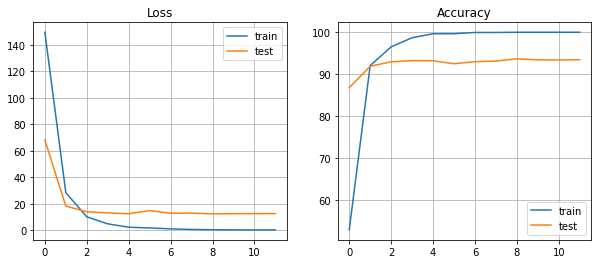

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].legend(['train','test'])
ax[0].grid()
ax[0].set_title("Loss")

ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].legend(['train','test'])
ax[1].grid()
ax[1].set_title("Accuracy")
plt.show()